# Table of Contents

### [Task 1. European Unemployment Rates Analysis - eurostat dataset](#1)
- [1.1. Pick a DataSet to analyse](#11)

- [1.2. Analyse Data and divide it into classes of interest](#12)

- [1.3. Build Choropleth Map](#13)

- [1.4. Compare Switzerland with the Rest of Europe](#14)

### [Task 2. Swiss Unemployment Rates Analysis - amstat dataset](#2)
- [2.1. Pick a DataSet to analyse](#21)

- [2.2. Choropleth map of Cantonal Unemployment Rates](#22)

- [2.3. Choropleth map of Cantonal Youth Unemployment Rates](#23)

### [Task 3. Swiss Unemployment Rates Analysis (including Swiss and foreign workers distinction) - amstat dataset ](#3)
- [3.1. Choropleth map between foreign and local unemployment rates](#31)

- [3.2. Bar plot of unemployment rates by age, canton and nationality](#32)

### [Task 4. Does the Röstigraben stand in the face of unemployment?](#4)

## Imports

In [1]:
import os
import pandas as pd
import json
import folium
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import IFrame
from IPython.core.display import HTML
%matplotlib inline

## Task 1. European Unemployment Rates Analysis - *eurostat* dataset <a class="anchor" id="1"></a>

### Assignment Instructions
Go to the eurostat website and try to find a dataset that includes the european unemployment rates at a recent date.

Use this data to build a `Choropleth map` which shows the unemployment rate in Europe at a country level. Think about the colors you use, how you decided to split the intervals into data classes or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.

### 1.1. Pick a Dataset<a class="anchor" id="11"></a>

In this task, we are asked to pick a data set which includes the european unemployment rates at a recent date. 
For this reason, we pick a dataset which represents the average per year of unemployment rate in the past few years. We still make sure that it includes Switzerland.

Note that this file can be downloaded either in `.csv` format or `.tsv` format. We choose the second one, since TSV is very efficient for Python to process, without losing any typing information, and also easy for humans to read. Let's load the selected file:

In [2]:
unemployment_df = pd.read_csv('tepsr_wc170.tsv', delimiter='\t|,', engine='python')
unemployment_df.head()

,unit,sex,age,isced11,geo\time,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,PC,T,Y15-24,TOTAL,AT,11.0 b,9.8,9.4 b,8.5,10.7,9.5,8.9,9.4,9.7,10.3,10.6,11.2
1,PC,T,Y15-24,TOTAL,BE,21.5 b,20.5,18.8,18.0,21.9,22.4,18.7 b,19.8,23.7,23.2,22.1,20.1
2,PC,T,Y15-24,TOTAL,BG,22.3 b,19.5,15.1,12.7 b,16.2,21.9 b,25.0 b,28.1,28.4,23.8,21.6,17.2
3,PC,T,Y15-24,TOTAL,CH,8.8 b,7.7,7.1,7.0,8.5,8.2 b,7.7,8.3,8.7,8.6,8.8,8.6
4,PC,T,Y15-24,TOTAL,CY,13.9 b,10.0,10.2,9.0,13.8 b,16.6,22.4,27.7,38.9,36.0,32.8,29.1


Let's analyse which values features may take:

In [3]:
for column in 'unit sex age isced11 geo\\time'.split(' '):
    print("{} values: {}".format(column, np.unique(unemployment_df[column])))

unit values: ['PC']
sex values: ['T']
age values: ['Y15-24' 'Y15-74' 'Y20-64' 'Y25-29' 'Y25-54' 'Y55-64']
isced11 values: ['TOTAL']
geo\time values: ['AT' 'BE' 'BG' 'CH' 'CY' 'CZ' 'DE' 'DK' 'EA18' 'EA19' 'EE' 'EL' 'ES'
 'EU27' 'EU28' 'FI' 'FR' 'HR' 'HU' 'IE' 'IS' 'IT' 'LT' 'LU' 'LV' 'MK' 'MT'
 'NL' 'NO' 'PL' 'PT' 'RO' 'SE' 'SI' 'SK' 'TR' 'UK']


The feature `isced11`, which may not be so intuitive, represents the `International Standard Classification of Education`. In this data set, the sum of all the categories is considered.

Furthermore, the feature `unit`, represents the unit of measure, which can be representad as a `percentage` or as `total`. In this case, it's always represented on percentage.

Note also that for `sex` they only consider the Total, which is `M` + `F`.

In `age`, the largest interval is `Y15-74`.

Let's proceed with filtering the desired data.

### 1.2. Analyse Data and divide it into classes of interest <a class="anchor" id="12"></a>

**Parameter Selection Criteria:** When selecting which classes to represent in our dataframe, several different approaches could be taken. The following choices are the ones that seem more meaningful to us:
- Age: `Y15-74`
- Geo\time: eliminate `EA18`, `EA19`, `EU27`, `EU28` as they are not countries
- Year: keep the most recent, as per instructions, 2016
- Columns that take only one value are deleted

In [4]:
chosen_year = '2016'
chosen_columns = ['geo\\time', chosen_year]
age_category = 'Y15-74'
excluded_geo_tags = ['EU28', 'EU27', 'EA19', 'EA18']
unemployment_df = unemployment_df[(unemployment_df['age']==age_category) 
                                  & (~unemployment_df['geo\\time'].isin(excluded_geo_tags))][chosen_columns]
unemployment_df.columns = ['Country', chosen_year]

** Numerical Conversion **

In [5]:
unemployment_df[chosen_year] = unemployment_df[chosen_year].apply(
    lambda figure: float(''.join([char for char in figure if char.isdigit() or char == '.'])))

### 1.3. Build Choropleth Map <a class="anchor" id="13"></a>

To build  map with the information above, we need somehow to associate the collected data with their locations.

For this, we start by importing the given `.json` file, which contains the geo-coordinates of European countries (liberal definition of EU):

In [6]:
europe_json_data = json.load(open('./topojson/europe.topojson.json'))

We need to make sure that all codes in our dataframe have a correspondence in the json file:

In [7]:
country_dict = {country['id'] : country['properties']['NAME'] 
                for country in europe_json_data['objects']['europe']['geometries']}
unemployment_df.Country = unemployment_df.Country.replace('EL', 'GR').replace('UK', 'GB').map(country_dict)
unemployment_df.set_index('Country', inplace=True)
unemployment_df.head()

,2016
Country,
Austria,6.0
Belgium,7.8
Bulgaria,7.6
Switzerland,5.0
Cyprus,13.0


We still need to make sure we don't draw the countries whose data is missing in the dataframe, to prevent visual confusion. Therefore, we just use JSON data for the countries we have in our dataframe:

In [8]:
europe_json_data['objects']['europe']['geometries'] = [
    country for country in europe_json_data['objects']['europe']['geometries'] 
    if country['properties']['NAME'] in set(unemployment_df.index)]

Now that we made sure that all the codes have their correspondency in the json file, we can draw the map.

In [9]:
def draw_map(location, zoom_start, geo_data, topojson, data, key_on, legend_names, line_opacity=0.2):
    """
    Drawing a Folium map with the data given, saving it and displaying the map and a link to view it.
    :param location: array of numbers, length 2
    :param zoom_start: int
    :param geo_data: json data
    :param topojson: string
    :param data: list of DataFrame instances
    :param key_on: string
    :param legend_names: list of strings
    :param line_opacity: float
    """
    name = '_'.join(legend_names)
    map_ = folium.Map(location=location, zoom_start=zoom_start)
    colors = ['YlOrRd', 'RdPu']
    for index in range(len(data)):
        threshold_scale = list(data[index].describe([.2,.4,.6,.8]).drop(['count', 'mean', 'std', '50%']))
        map_.choropleth(geo_data=geo_data,
                        topojson=topojson,
                        data=data[index],
                        key_on=key_on,
                        fill_color=colors[index % len(colors)], fill_opacity=0.7/len(data), 
                        line_opacity=line_opacity, line_weight=2,
                        name=legend_names[index],
                        legend_name=legend_names[index],
                        threshold_scale=threshold_scale)
    if len(data) > 1:
        folium.LayerControl().add_to(map_)
    filename = '{}.html'.format(name)
    map_.save(filename)
    url = "https://khalilmrini.github.io/ADA2017/03%20-%20Interactive%20Viz/{}".format(filename)
    display(HTML('<a  href="{}" target="_blank">If you don\'t view this using NBViewer, click here to view the map in a new tab.</a>'.format(url)))
    return IFrame(url, width=1000, height=600)

We draw the map.

In [10]:
draw_map(location=[55,10], zoom_start=3, geo_data=europe_json_data, topojson='objects.europe', 
         data=[unemployment_df['2016']], key_on='feature.properties.NAME',
         legend_names=['Unemployment rate in Europe in 2016'])

On the map above we can see how the unemployment rate is distributed through Europe. We check that Greece and neighbouring Macedonia are suffering from a high unemployment rate.

### 1.4. Compare Switzerland with the Rest of Europe <a class="anchor" id="14"></a>

We can also verify that Switzerland is one of the countries with the lowest unemployment rate.

In [11]:
unemployment_df.groupby(
    by=[unemployment_df.index == 'Switzerland'])[['2016']].mean().rename(
    index={True: 'Switzerland', False: 'Rest of Europe'})

,2016
Rest of Europe,8.90625
Switzerland,5.00000


Switzerland has an average unemployment rate lower than the rest of Europe. But it is not the country with the lowest unemployment rate. In the bar plot below, it is highlighted in red, and has a higher unemployment rate than 6 other European countries.

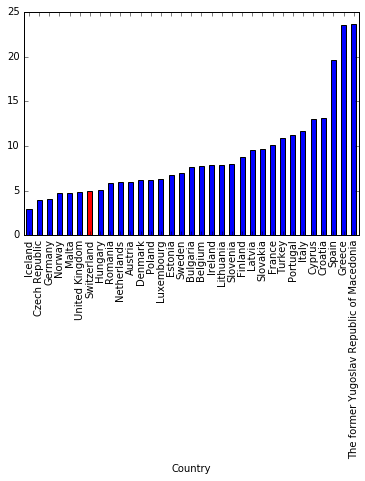

In [12]:
sorted_unemployment_df = unemployment_df.sort_values(by='2016')
sorted_unemployment_df.plot.bar(legend=False,
                                color=[['r' if country == 'Switzerland' else 'b' 
                                        for country in sorted_unemployment_df.index]]);

## Task 2. Swiss Unemployment Rates Analysis - *amstat* dataset <a class="anchor" id="2"></a>

### Assignment Instructions

Go to the amstat website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

### 2.1. Pick a DataSet to analyse <a class="anchor" id="21"></a>

We picked the dataset covering the unemployment rates per canton in Switzerland for September 2017. We only counted the registered jobless (Chômeurs Inscrits).

In [13]:
ch_unemployment_df = pd.read_csv('ch_unemployment.csv',
                                 engine='python',
                                 encoding='utf-16').dropna(axis=1).drop(0).applymap(
    lambda cell: float(cell) if cell.replace('.','').isdigit() else cell).drop('Total', axis=1)
print("In September 2017, Switzerland recorded an unemployment rate of {}%.".format(
    ch_unemployment_df['Septembre 2017'][27]))

In September 2017, Switzerland recorded an unemployment rate of 3.0%.


We notice that in September 2017, the unemployment rate in all of Switzerland was 3%, rather than the 5% reported by Eurostat.

### 2.2. Choropleth map of Cantonal Unemployment Rates  <a class="anchor" id="22"></a>

We load the geographic `json` file and add a column called `Canton_JSON` to compare what names are used for cantons.

In [14]:
ch_json = json.load(open('./topojson/ch-cantons.topojson.json'))
ch_unemployment_df.drop(27, inplace=True)
ch_unemployment_df['Canton_JSON'] = [country['properties']['name'] 
                                     for country in ch_json['objects']['cantons']['geometries']]
ch_unemployment_df.head()

,Canton,Septembre 2017,Canton_JSON
1,Zurich,3.3,Zürich
2,Berne,2.4,Bern/Berne
3,Lucerne,1.7,Luzern
4,Uri,0.6,Uri
5,Schwyz,1.7,Schwyz


We notice that names of the cantons match in order. Then we can just use the ones from the `json` file.

In [15]:
ch_canton_dict = {canton[1]['Canton']: canton[1]['Canton_JSON'] for canton in ch_unemployment_df.iterrows()}
ch_unemployment_df['Canton'] = ch_unemployment_df['Canton_JSON']
ch_unemployment_df.drop('Canton_JSON', axis=1, inplace=True)
ch_unemployment_df.set_index('Canton', inplace=True)
ch_unemployment_df.head()

,Septembre 2017
Canton,
Zürich,3.3
Bern/Berne,2.4
Luzern,1.7
Uri,0.6
Schwyz,1.7


We draw the map.

In [16]:
ch_location = [46.9, 8.228]
ch_zoom_start = 8
draw_map(location=ch_location, zoom_start=ch_zoom_start, geo_data=ch_json, topojson='objects.cantons',
         data=[ch_unemployment_df['Septembre 2017']], key_on='feature.properties.name',
         legend_names=['Unemployment rate in Switzerland in September 2017'])

We observe the lowest unemployment rates in the rural southeast part of the country, and a general pattern of higher unemployment rates in the urban and French-speaking parts of the country, with Zurich and Geneva reaching visible records.

### 2.3. Choropleth map of Cantonal Youth Unemployment Rates <a class="anchor" id="24"></a>

We took a dataset with the youth unemployment rates in the cantons of Switzerland.

In [17]:
ch_youth_unemployment_df = pd.read_csv('ch_unemployment_for_youth.csv',
                                       engine='python',
                                       encoding='utf-16').dropna(axis=1).drop(0).drop(27).applymap(
    lambda cell: float(cell) if cell.replace('.','').isdigit() else cell).drop('Total', axis=1)
ch_youth_unemployment_df.Canton = ch_youth_unemployment_df.Canton.map(ch_canton_dict)
ch_youth_unemployment_df.set_index('Canton', inplace=True)
ch_youth_unemployment_df.head()

,Septembre 2017
Canton,
Zürich,3.7
Bern/Berne,2.8
Luzern,2.1
Uri,0.5
Schwyz,1.6


We build a map that compares, at the cantonal level, the unemployment rate for all the population and the one for youth. We compare them by superposing them. One can also filter the data right on the map.

In [18]:
draw_map(location=ch_location, zoom_start=ch_zoom_start, geo_data=ch_json, topojson='objects.cantons',
         data=[ch_unemployment_df['Septembre 2017'], ch_youth_unemployment_df['Septembre 2017']], 
         key_on='feature.properties.name',
         legend_names=['Unemployment rate in Switzerland', 'Youth unemployment rate in Switzerland'])

## Task 3. Swiss Unemployment Rates Analysis (including Swiss and foreign workers distinction) - amstat dataset  <a class="anchor" id="3"></a>

### Assignment Instructions

Use the amstat website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between Swiss and foreign workers.

The Economic Secretary (SECO) releases a monthly report on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for foreign (5.1%) and Swiss (2.2%) workers.

Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (hint The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

### 3.1. Choropleth map between foreign and local unemployment rates <a class="anchor" id="31"></a>

We pick a dataset that gives unemployment rates by nationality and by canton for September 2017. Then we compute in each canton the difference between the unemployment rates of foreigners and the one for the Swiss.

In [19]:
ch_unemployment_by_nationality_df = pd.read_csv('ch_unemployment_by_nationality.csv',
                                 engine='python',
                                 encoding='utf-16').drop(0)[:-1].drop(['Total', 'Mois'], axis=1).applymap(
    lambda cell: float(cell) if cell.replace('.','').isdigit() else cell)
ch_unemployment_by_nationality_df.Canton = ch_unemployment_by_nationality_df.Canton.map(ch_canton_dict)
ch_unemployment_by_nationality_df = ch_unemployment_by_nationality_df.pivot_table(
    index='Canton', columns=['Nationalité'])['Septembre 2017'].aggregate(
    lambda row: row['Etrangers'] - row['Suisses'], axis=1)
ch_unemployment_by_nationality_df.head()

Canton
Aargau                    3.5
Appenzell Ausserrhoden    2.0
Appenzell Innerrhoden     1.5
Basel-Landschaft          2.6
Basel-Stadt               1.8
dtype: float64

The map below depicts the differences between unemployment rates of foreigners and locals by canton. The darker the color, the more a foreigner is likely to be unemployed compared to a local. We notice the biggest differences around the northwestern parts of the country, especially in Jura.

In [20]:
draw_map(location=ch_location, zoom_start=ch_zoom_start, geo_data=ch_json, topojson='objects.cantons',
         data=[ch_unemployment_by_nationality_df], key_on='feature.properties.name',
         legend_names=['Difference in unemployment rates in Switzerland between locals and foreigners'])

### 3.2. Bar plot of unemployment rates by age, canton and nationality <a class="anchor" id="32"></a>

We pick a dataset that gives absolute numbers of the registered jobless (Chômeurs inscrits) and compute what percentage does each of three age categories represent of the total population.

The three age categories are: youth between 15 and 24, adults between 25 and 49, and seniors that are 50 and older.

We chose percentage as absolute numbers are not useful to compare different cantons where population numbers differ sharply.

In [21]:
age_column = "Classes d'âge 15-24, 25-49, 50 ans et plus"
ch_age_nationality_unemployment_df = pd.read_csv('ch_unemployment_by_age_and_nationality.csv',
                                                 engine='python',
                                                 encoding='utf-16').drop(
    ['Mois', 'Unnamed: 3'], axis=1).dropna().drop(0).applymap(
    lambda cell: int(cell.replace('\'','')) if cell.replace('\'','').isdigit() else cell).applymap(
    lambda cell: '15-24' if cell == 1 else '25-49' if cell == 2 else '50+' if cell == 3 else cell).groupby(
    ['Canton', 'Nationalité', age_column])['Septembre 2017'].sum().unstack(age_column).drop('Total', axis=1).apply(
    lambda row: row/np.sum(row), axis=1)
ch_age_nationality_unemployment_df.head()

Classes d'âge 15-24, 25-49, 50 ans et plus     15-24     25-49       50+
Canton                       Nationalité                                
Appenzell Rhodes-Extérieures Etrangers      0.117318  0.603352  0.279330
                             Suisses        0.127907  0.438953  0.433140
Appenzell Rhodes-Intérieures Etrangers      0.260870  0.434783  0.304348
                             Suisses        0.256410  0.358974  0.384615
Argovie                      Etrangers      0.120072  0.657683  0.222245

We display the following bar plot, with the indexes being (Canton, Nationality). There is a tendency to have seniors represented a bigger share in the unemployed for the Swiss population. However, the adults generally hold the lion's share of the unemployed population.

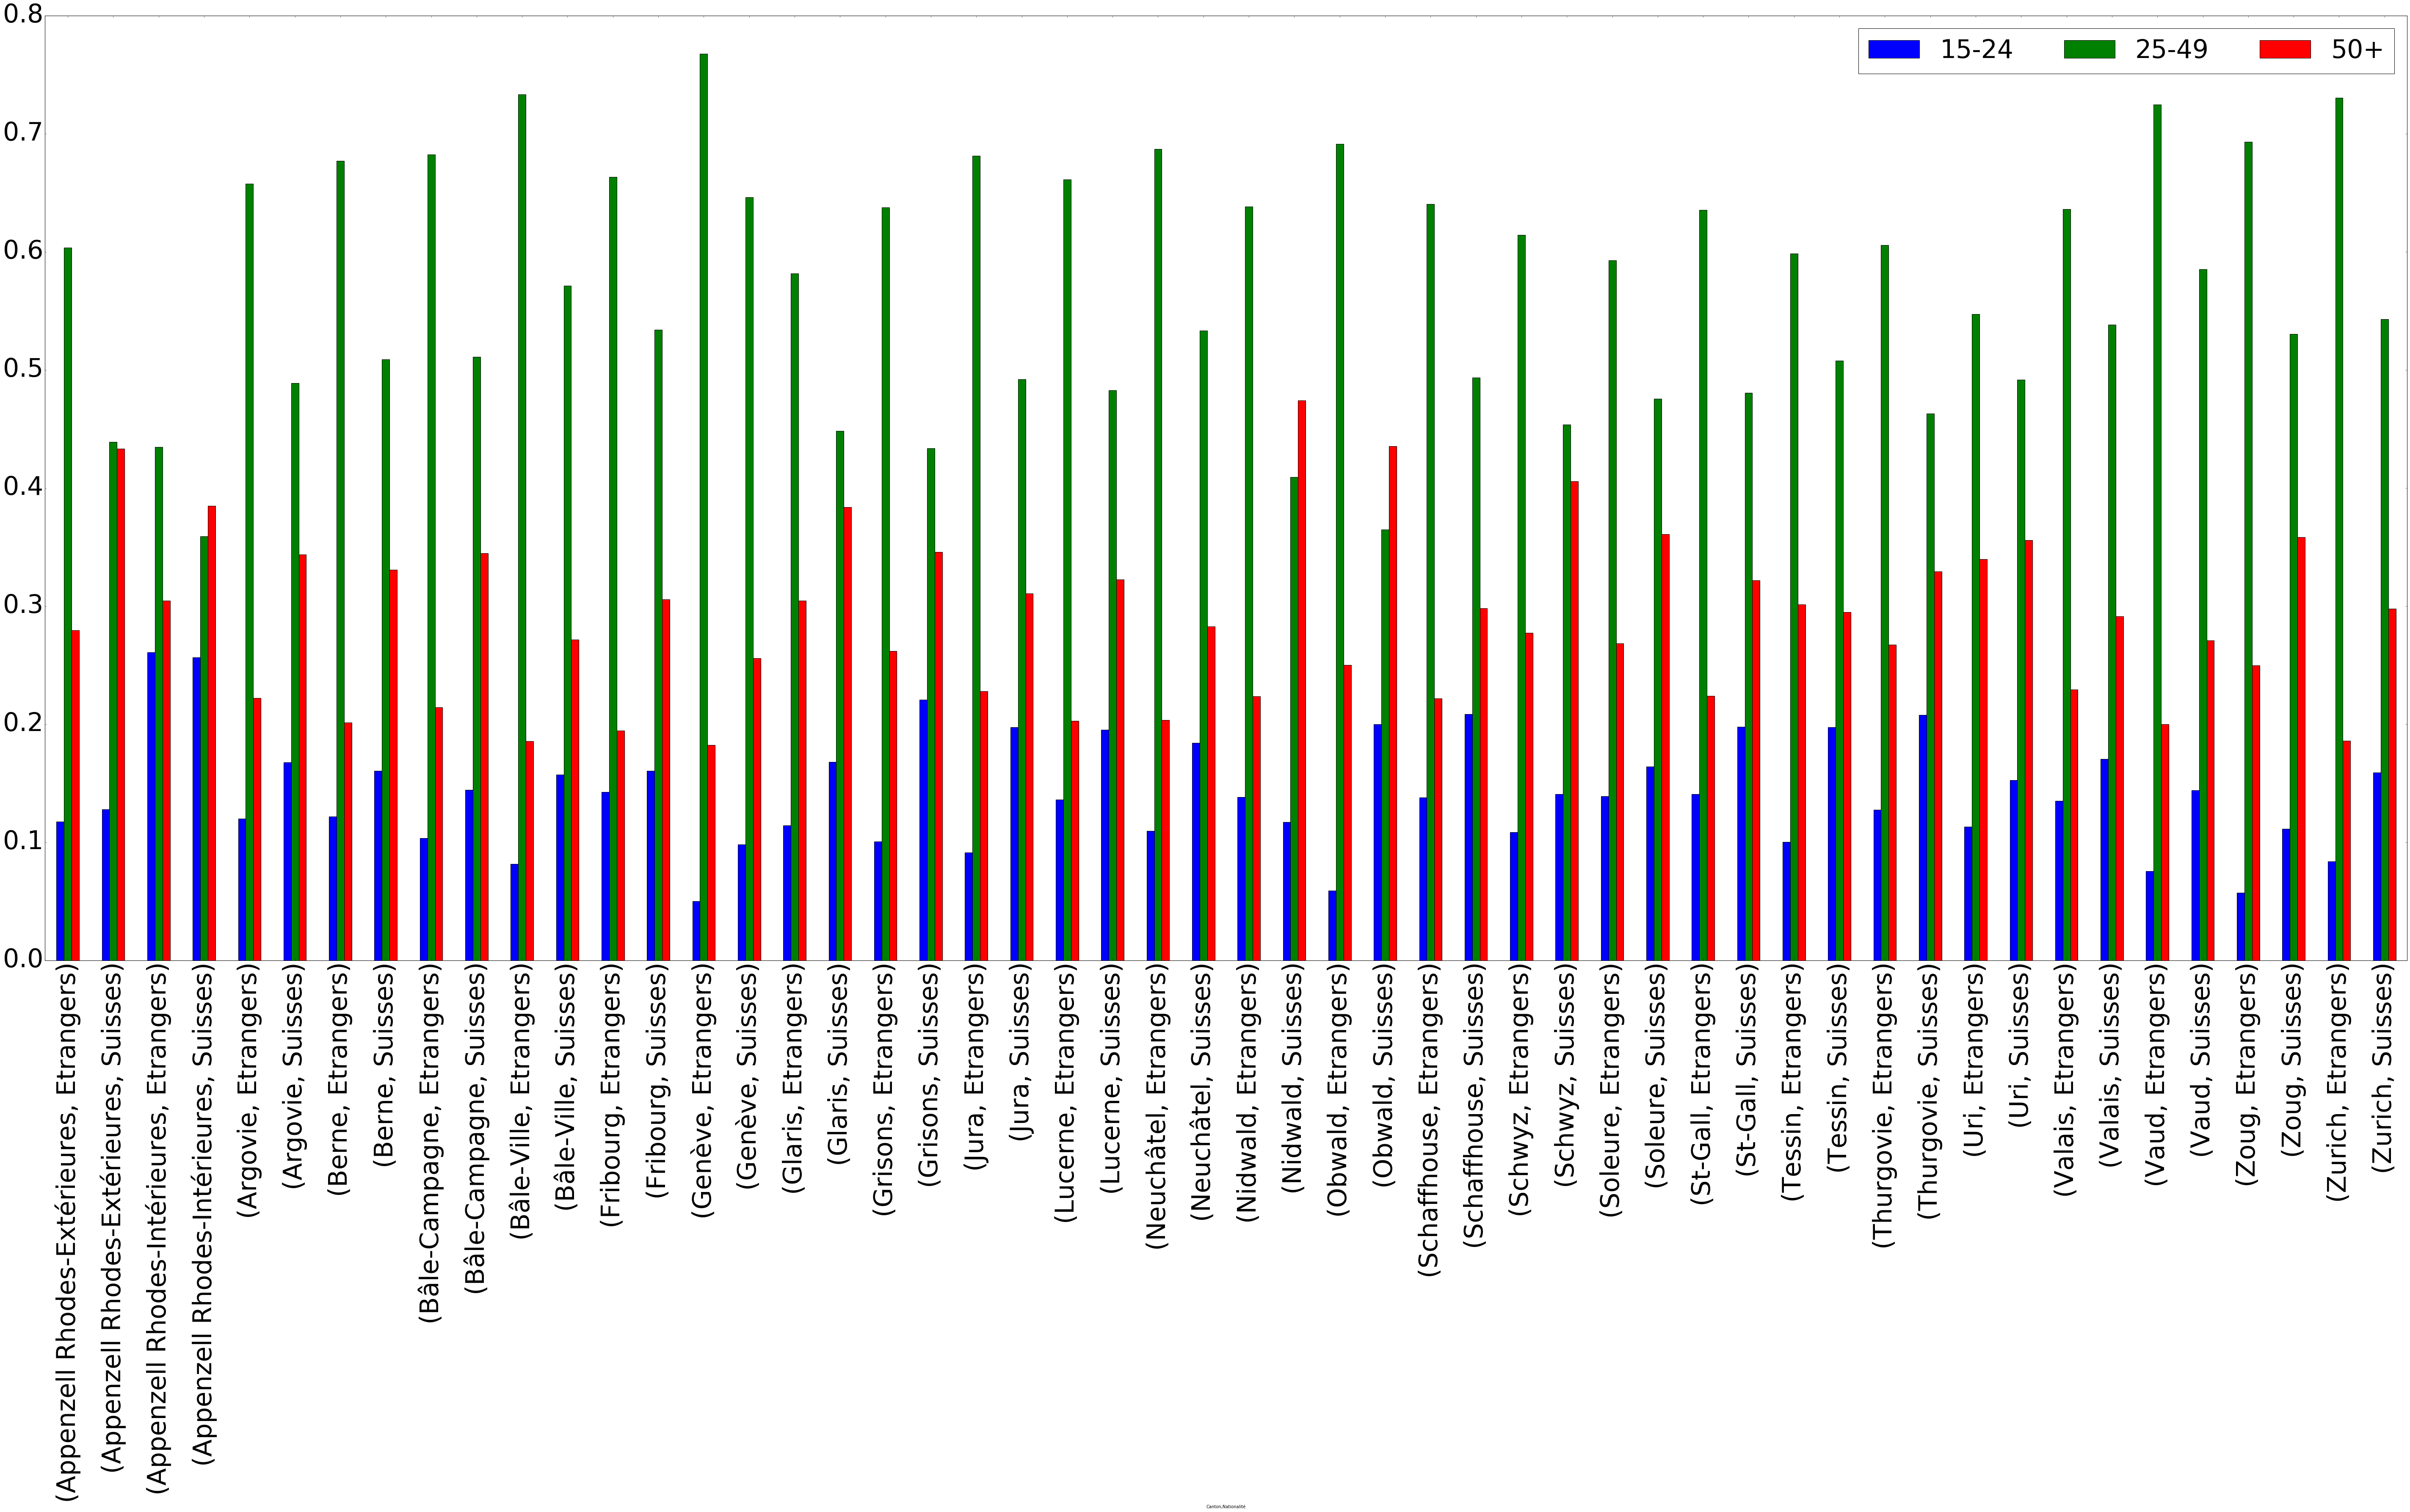

In [22]:
ch_age_nationality_unemployment_df.plot.bar(figsize=(100,40), fontsize=60);
plt.legend(fontsize=60, ncol=3);

## Task 4. Does the Röstigraben stand in the face of unemployment?  <a class="anchor" id="4"></a>

### Assignment Instructions

**BONUS:** using the map you have just built, and the geographical information contained in it, could you give a rough estimate of the difference in unemployment rates between the areas divided by the Röstigraben?

### Answer

We pick the six majority-French-speaking cantons of Switzerland and compute their average unemployment rate, and do the same for the remaining cantons.

In [23]:
cantons_romands = 'Genève Vaud Neuchâtel Fribourg Jura Valais/Wallis'.split(' ')
roestigraben_dict = {True: 'West of the Röstigraben', False: 'East of the Röstigraben'}
roestigraben_df = ch_unemployment_df.groupby(
    by=[canton in cantons_romands for canton in ch_unemployment_df.index]).mean().rename(roestigraben_dict)
roestigraben_df

,Septembre 2017
East of the Röstigraben,2.055000
West of the Röstigraben,4.083333


We notice that the cantons west of the Röstigraben have an average cantonal unemployment rate that is about double the one found for cantons east of the Röstigraben. This shows the Röstigraben still stands for cantonal unemployment rates in Switzerland.

In [24]:
roestigraben_by_canton_df = ch_unemployment_df.apply(
    lambda row: [roestigraben_df['Septembre 2017'].loc[roestigraben_dict[canton in cantons_romands]] 
                 for canton in row.index])['Septembre 2017']
draw_map(location=ch_location, zoom_start=ch_zoom_start, geo_data=ch_json, topojson='objects.cantons',
         data=[roestigraben_by_canton_df], key_on='feature.properties.name', line_opacity=0,
         legend_names=['Difference in unemployment rates in Switzerland between locals and foreigners'])